# Tópico 14 – Intervalos de Confiança [<img src="images/colag_logo.svg" style="float: right; vertical-align: middle; width: 42px; height: 42px;">](https://colab.research.google.com/github/urielmoreirasilva/urielmoreirasilva.github.io/blob/main/aulas/T%C3%B3pico%2014/14%20%E2%80%93%20IntervalosDeConfianca.ipynb) [<img src="images/github_logo.svg" style="float: right; margin-right: 12px; vertical-align: middle; width: 36px; height: 36px;">](https://github.com/urielmoreirasilva/urielmoreirasilva.github.io/blob/main/aulas/T%C3%B3pico%2014/14%20%E2%80%93%20IntervalosDeConfianca.ipynb)

Após aprender a quantificar a incerteza de uma estimativa através dos intervalos de confiança construídos via bootstrap, é hora de nos aprofundarmos na interpretação desses intervalos, e formalizar algumas noções da "centralidade" e da "variabilidade" dos valores de uma distribuição. Ao longo dessa aula, introduziremos também outras maneiras de quantificar a incerteza e a probabilidade de um conjunto de valores de uma distribuição através de uma construção matemática, baseada na teoria de Probabilidade. [*]

### Resultados Esperados

1. Aprender a interpretar intervalos de confiança. [*]
1. Aprender a identificar as situações onde espera-se que o bootstrap dê bons resultados (ou não).
1. Introduzir e definir medidas de tendência central e de dispersão.
1. Introduzir e aprender como utilizar a Desigualdade de Chebyshev para quantificar a probabilidade de que os valores de uma distribuição estejam perto (ou longe) de sua média. 

### Referências
- [CIT, Capítulo 13](https://inferentialthinking.com/)

Material adaptado do [DSC10 (UCSD)](https://dsc10.com/) por [Flavio Figueiredo (DCC-UFMG)](https://flaviovdf.io/fcd/) e [Uriel Silva (DEST-UFMG)](https://urielmoreirasilva.github.io)

In [3]:
# [*] [*] [*]

import numpy as np
import babypandas as bpd
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

np.set_printoptions(threshold=20, precision=2, suppress=True)
pd.set_option("display.max_rows", 7)
pd.set_option("display.max_columns", 8)
pd.set_option("display.precision", 2)

## Interpretando intervalos de confiança

### Recapitulando: Salários dos funcionários públicos da cidade de San Diego

Vamos rodar nosso código da aula passada novamente para calcular um intervalo de 95% de confiança para o salário mediano de todos os funcionários da cidade de San Diego, tomando como base uma amostra de 500 indivíduos.

**Passo 1**: Coletar uma única amostra de 500 indivíduos da população.

In [2]:
population = bpd.read_csv('data/2022_salaries.csv').get(['TotalWages'])
population_median = population.get('TotalWages').median()
population_median # Can't see this in real life!

78136.0

In [3]:
np.random.seed(38) # Magic to ensure that we get the same results every time this code is run.
my_sample = population.sample(500)
sample_median = my_sample.get('TotalWages').median()
sample_median

76237.0

**Passo 2**: Bootstrap! Reamostrar um número grande de vezes da nossa amostra e, para cada reamostragem, calcular a mediana correspondente. Teremos assim uma distribuição empírica da mediana amostral.

In [4]:
np.random.seed(38) # Magic to ensure that we get the same results every time this code is run.

# Bootstrap the sample to get more sample medians.
n_resamples = 5000
boot_medians = np.array([])

for i in np.arange(n_resamples):
    resample = my_sample.sample(500, replace=True)
    median = resample.get('TotalWages').median()
    boot_medians = np.append(boot_medians, median)
    
boot_medians

array([76896. , 72945. , 73555. , ..., 74431. , 75868. , 78601.5])

**Passo 3**: Tomar os percentis correspondentes à uma frequência total de aproximadamente 95% da distribuição empírica das medianas amostrais (i.e. `boot_medians`). Esse será nosso intervalo de 95% de confiança.

In [5]:
left = np.percentile(boot_medians, 2.5)
right = np.percentile(boot_medians, 97.5)

# Therefore, our interval is:
[left, right]

[68469.0, 81253.5]

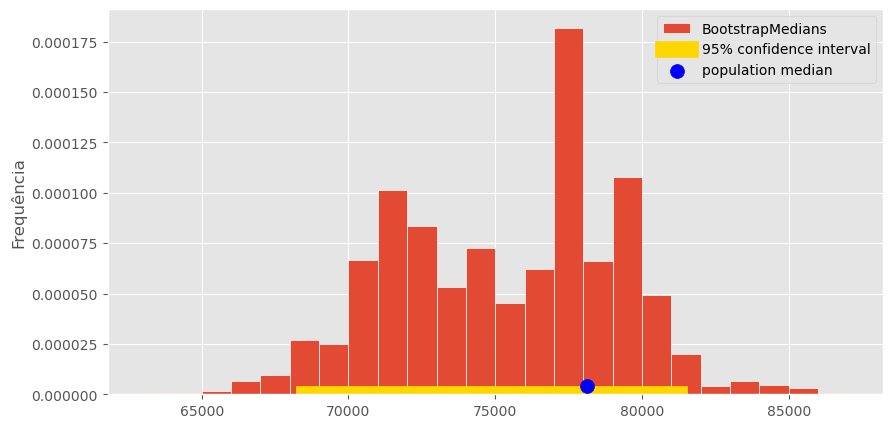

In [6]:
bpd.DataFrame().assign(BootstrapMedians=boot_medians).plot(kind='hist', density=True, bins=np.arange(63000, 88000, 1000), ec='w', figsize=(10, 5))
plt.plot([left, right], [0, 0], color='gold', linewidth=12, label='95% confidence interval');
plt.scatter(population_median, 0.000004, color='blue', s=100, label='population median').set_zorder(3)
plt.legend()
plt.ylabel("Frequência");

### Intervalos de confiança são estimativas _intervalares_ para um parâmetro

Aprendemos na aula passada que, com base nos intervalos de confiança (IC), ao invés de simplesmente afirmar

> "podemos dizer que a mediana populacional é _próxima_ da mediana amostral, \\$76,237",

nós podemos afirmar

> "podemos dizer, _com 95% de confiança_, que mediana populacional está entre \\$68,469 e \\$81,253.50".

**Na aula de hoje, vamos responder as seguintes perguntas**: "Mas afinal, o que 95% de confiança significa?" "Sobre o quê estamos confiantes?" "Esse tipo de técnica sempre funciona?"

### Interpretando intervalos de confiança

- Criamos um IC que contém 95% das medianas das nossas amostras bootstrap.
- Esperamos que a mediana populacional também esteja contida nesse IC.
- Porém, o quão seguros estamos desse fato? **Dizemos que "podemos afirmar isso com 95% de confiança", mas o que isso significa?**

### Capturando o verdadeiro valor do parâmetro

- Considere o seguinte passo-a-passo:
    1. Coletar uma **amostra nova** da população.
    1. Bootstrap: reamostrar dessa amostra várias vezes, calculando a estatística de interesse (por exemplo a mediana) em cada amostra.
    1. Construir um IC95%.

- Um nível de 95% de confiança então significa que, **em aproximadamente 95% das vezes em que realizamos esse processo, o intervalo criado conterá o verdadeiro valor do parâmetro**.
    - Em outras palavras: se pudéssemos repetir nosso experimento aleatório um número muito grande de vezes, 95% dos intervalos de confiança vão conter o verdadeiro valor do parâmetro.

- Dessa forma, a confiança reside no **processo** que gera o intervalo! [*]

### Múltiplos intervalos de confiança

- Repetimos o passo-a-passo descrito acima $M = 200$ vezes, obtendo $M = 200$ ICs diferentes.
    - Fizemos isso de antemão (demorou um bom tempo) e salvamos os resultados em um arquivo.
- Os ICs obtidos estão contidos no array `many_cis` abaixo.

In [4]:
many_cis = np.load('data/many_cis.npy')
many_cis

array([[72881.5 , 85383.32],
       [66727.19, 81871.47],
       [65449.32, 82001.4 ],
       ...,
       [64915.5 , 81814.85],
       [66702.5 , 79711.  ],
       [67996.76, 82105.84]])

Na visualização abaixo:
- A <span style="color:blue">linha azul</span> representa o parâmetro populacional. **Lembre que o parâmetro não é aleatório.**
- Cada <span style="color:gold">linha dourada</span> representa um IC diferente, obtido utilizado o passo-a-passo descrito anteriormente.
- Note que a _maioria_ dos ICs contém o parâmetro verdadeiro, mas _não todos_!

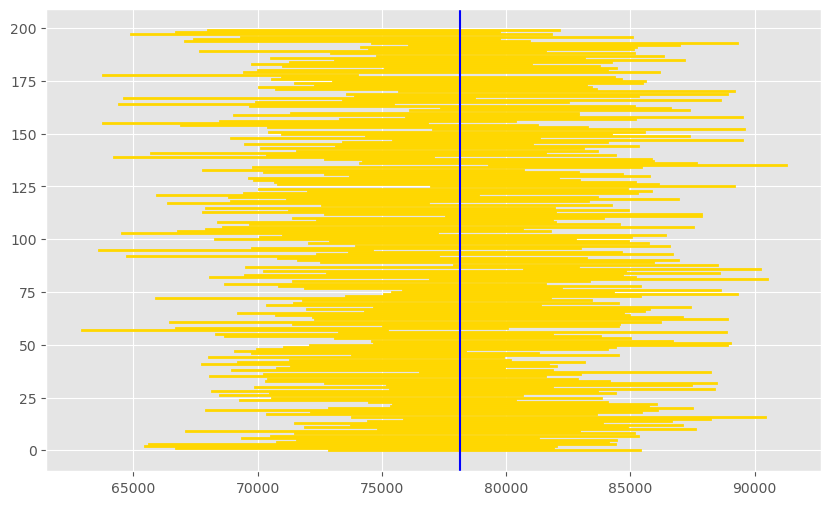

In [10]:
plt.figure(figsize=(10, 6))
for i, ci in enumerate(many_cis):
    plt.plot([ci[0], ci[1]], [i, i], color='gold', linewidth=2)
plt.axvline(x=population_median, color='blue');

### Quais ICs não contém o parâmetro populacional?

In [5]:
plt.figure(figsize=(10, 6))
count_outside = 0
for i, ci in enumerate(many_cis):
    if ci[0] > population_median or ci[1] < population_median:
        plt.plot([ci[0], ci[1]], [i, i], color='gold', linewidth=2)
        count_outside = count_outside + 1
plt.axvline(x=population_median, color='blue');

NameError: name 'population_median' is not defined

<Figure size 1000x600 with 0 Axes>

In [6]:
count_outside

0

- 11 dos nossos $M = 200$ ICs não contém o verdadeiro valor do parâmetro.
- Por outro lado, isso significa que 189/200, ou 94.5% dos ICs, contém sim o parâmetro populacional!
    - Não coincidentemente, 94.5% é bem próximo de 95%!

- Na prática, como coletamos apenas **uma única amostra**, teremos apenas **um único IC correspondente**, e não saberemos com certeza se esse IC contém ou não o verdadeiro valor do parâmetro.
    - Se em um certo sentido nossa amostra não for "boa", isto é, com uma distribuição que seja próxima da distribuição populacional, então nossa inferência será prejudicada.

### Escolhendo o nível de confiança

- Quando coletamos uma amostra "ruim" (isto é, que não tenha uma distribuição próxima da populacional), ao construírmos nosso IC é bem provável que esse IC não contenha o verdadeiro valor do parâmetro.
    - Podemos tentar remediar essa situação escolhendo um nível de confiança mais apropriado, mas note que existe um _tradeoff_ associado à isso! 

- Se, por exemplo, escolhermos um nível de confiança igual a 99%: 
    - aproxidamente apenas 1% das vezes nosso IC não conterá o verdadeiro valor do parâmetro (o que é ótimo!). Porém, ...
    - nossos ICs serão muito largos, e logo não muito úteis na prática.

- Se por outro lado escolhermos um nível de confiança igual a 80%: 
    - muitas das vezes (~20%) o IC não conterá o verdadeiro valor do parâmetro (o que não é tão bom assim). Porém, ...
    - nossos ICs nesse caso serão bem mais curtos, e logo mais precisos.

- O _tradeoff_ principal nesse contexto é então entre **confiança e precisão**.
    - Quanto **mais confiante** eu estou de que uma afirmativa é verdadeira, **menos preciso** essa afirmativa será, e vice-versa.
    - Por exemplo, se eu afirmo que hoje vai começar a chover _exatamente_ às 13:14 (uma afirmativa bem precisa), em geral eu quase sempre estarei errado sobre isso (e, logo, pouco confiante).
    - Por outro lado, se eu afirmo que vai chover _algum dia_ desse ano (uma afirmativa muito precisa), em geral eu quase sempre estarei correto sobre isso (e, logo, muito confiante).   

- Para um dado nível de confiança fixo, como então podemos fazer com que nosso IC seja mais curto (i.e. mais preciso)?
    - Coletando uma amostra maior!
    - Veremos adiante mais detalhes sobre a relação entre o tamanho amostral, o nível de confiança e a largura do IC. 

### Como _não_ interpretar intervalos de confiança

Fato: intervalos de confiança podem ser complicados de interpretar corretamente.

In [13]:
# Our interval:
print('Nosso IC95% é dado por:')
[left, right]

Nosso IC95% é dado por:


[68469.0, 81253.5]

**O intervalo acima contém 95% de todos os salários da população? Não!** ❌

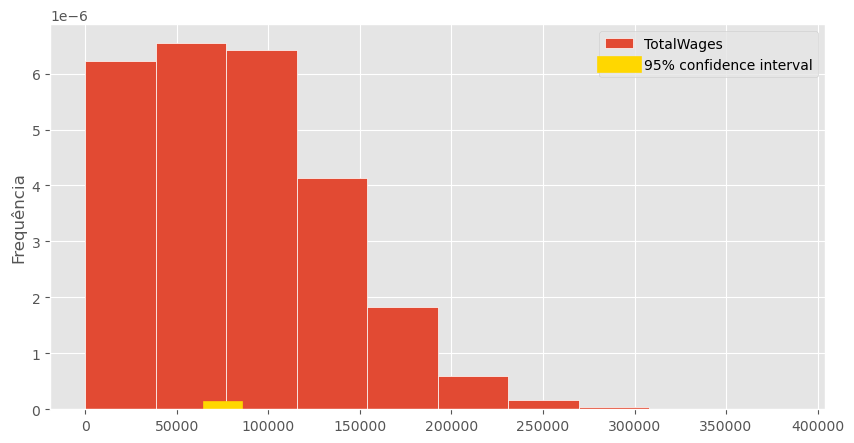

In [14]:
population.plot(kind='hist', y='TotalWages', density=True, ec='w', figsize=(10, 5))
plt.plot([left, right], [0, 0], color='gold', linewidth=12, label='95% confidence interval');
plt.legend()
plt.ylabel("Frequência");

Por outro lado, o IC95% _contém sim_ 95% de todos os salários medianos obtidos pelo bootstrap.

> Em outras palavras, o IC95% contém 95% de todos os valores da _distribuição bootstrap_ (mas não da população).

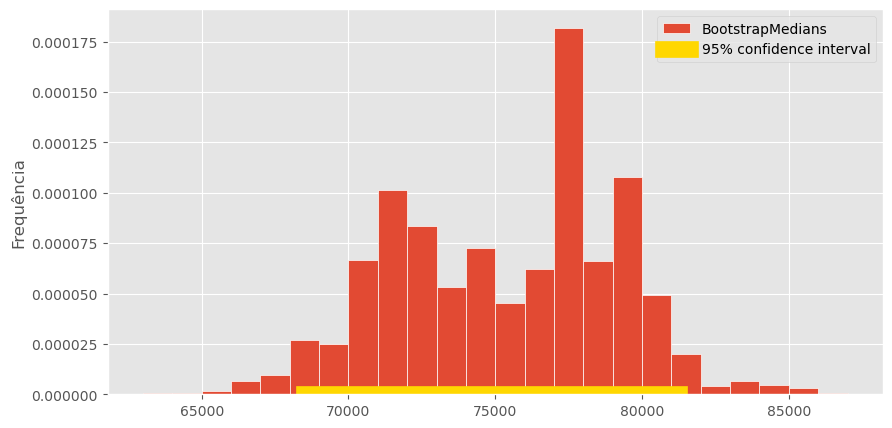

In [15]:
bpd.DataFrame().assign(BootstrapMedians=boot_medians).plot(kind='hist', density=True, bins=np.arange(63000, 88000, 1000), ec='w', figsize=(10, 5))
plt.plot([left, right], [0, 0], color='gold', linewidth=12, label='95% confidence interval');
plt.legend()
plt.ylabel("Frequência");

In [16]:
# Our interval:
print('Nosso IC95%:')
[left, right]

Nosso IC95%:


[68469.0, 81253.5]

**Então com 95% de probabilidade esse intervalo contém o parâmetro populacional? Também não!** ❌

E porque não?
- O parâmetro populacional é fixo, i.e. **não-aleatório**(embora desconhecido).
    - O intervalo obtido também é não-aleatório (embora o processo que o produza seja).
    - Para um dado intervalo, ou o parâmetro populacional está no intervalo ou não está. Logo, também não há aleatoriedade quanto a esse ponto.
- Lembre que o nível de confiança (nesse caso 95%) está relacionado ao quão preciso estamos sendo ao construirmos o intervalo.
    - Dessa forma, todo o processo de criar o IC (amostragem, bootstrapping e finalmente produzir o intervalo) produz um IC que contém o verdadeiro valor do parâmetro em aproximadamente 95% dos casos.

## Resumo [*]

#### Bootstrap e intervalos de confiança

- O boostrap nos fornece uma maneira de construir uma distribuição empírica de uma estatística com base em uma única amostra. Com a distribuição bootstrap, podemos criar intervalos de $\gamma\%$ de confiança tomando como limite inferior e superior percentis que contenham $\gamma\%$ da distribuição bootstrap.
- Um IC construído dessa maneira nos permite quantificar a incerteza sobre a nossa estimativa do parâmetro populacional.
    - Dessa forma, ao invés de reportar apenas uma estimativa pontual para o parâmetro de interesse, podemos reportar um conjunto de estimativas.
- **Intervalos de confiança precisam ser interpretados com cuidado.** A "confiança" reside no processo que gera os intervalos, e não em um IC em particular.